In [7]:
!pip install gdown -q

!gdown --id 13rcB6h9uzJj5DwWJFQRsZh32cKZ2t55R -O /content/train_face224.zip -q
!unzip -q /content/train_face224.zip -d /content/train_face224

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(


In [ ]:
# =========================
# 1. IMPORT LIBRARIES
# =========================
import os
import random
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from collections import defaultdict

In [15]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [16]:
# =========================
# 3. TRANSFORM / AUGMENTASI
# =========================

# Transform untuk TRAIN (dengan augmentasi)
train_transform = transforms.Compose([
    # 1) Sedikit geser & zoom tapi tetap 224x224
    transforms.RandomResizedCrop(
        size=224,
        scale=(0.9, 1.0),     # jangan terlalu kecil
        ratio=(0.9, 1.1),     # hampir square, aman buat wajah
    ),
    # 2) Flip kiri-kanan (pose terbalik dikit masih masuk akal)
    transforms.RandomHorizontalFlip(p=0.5),
    # 3) Rotasi kecil
    transforms.RandomRotation(degrees=10),
    # 4) Variasi cahaya & warna (ringan)
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.15,
        hue=0.02,
    ),
    # (Optional, boleh dibuang kalau takut terlalu agresif)
    # transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),

    # 5) Convert ke tensor + normalisasi ImageNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Transform untuk VALIDATION / TEST (TANPA augmentasi)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [ ]:
# =========================
# 4. DATASET & DATALOADER
# =========================

data_root = "/content/train_face224"

base_dataset = ImageFolder(data_root)
class_names = base_dataset.classes
num_classes = len(class_names)
print("Jumlah kelas:", num_classes)
print("Contoh kelas:", class_names[:5])

val_ratio = 0.2
num_samples = len(base_dataset)
targets = base_dataset.targets  # list label per sample

# Kumpulkan indeks per kelas
class_to_indices = defaultdict(list)
for idx, label in enumerate(targets):
    class_to_indices[label].append(idx)

train_indices = []
val_indices = []

for label, idx_list in class_to_indices.items():
    # acak indeks di kelas ini
    random.shuffle(idx_list)
    n_total = len(idx_list)
    
    # jumlah val untuk kelas ini (minimal 1 kalau sampelnya > 1)
    n_val = int(n_total * val_ratio)
    if n_val == 0 and n_total > 1:
        n_val = 1

    val_idx_for_class = idx_list[:n_val]
    train_idx_for_class = idx_list[n_val:]

    val_indices.extend(val_idx_for_class)
    train_indices.extend(train_idx_for_class)

print(f"Total train indices: {len(train_indices)}")
print(f"Total val indices  : {len(val_indices)}")

# Dataset dengan transform
train_dataset_full = ImageFolder(data_root, transform=train_transform)
val_dataset_full   = ImageFolder(data_root, transform=val_transform)

train_dataset = Subset(train_dataset_full, train_indices)
val_dataset   = Subset(val_dataset_full,   val_indices)

print(f"Train samples: {len(train_dataset)}")
print(f"Val   samples: {len(val_dataset)}")

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size,
                          shuffle=False, num_workers=2, pin_memory=True)

Jumlah kelas: 70
Contoh kelas: ['Abraham Ganda Napitu', 'Abu Bakar Siddiq Siregar', 'Ahmad Faqih Hasani', 'Aldi Sanjaya', 'Alfajar']
Train samples: 227
Val   samples: 57


In [ ]:
# =========================
# 5. MODEL: EFFICIENTNET-B0
# =========================

weights = EfficientNet_B0_Weights.IMAGENET1K_V1
model = efficientnet_b0(weights=weights)

num_classes = len(class_names)
in_features = model.classifier[1].in_features

# classifier baru: Dropout lebih besar
model.classifier[1] = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(in_features, num_classes)
)

model = model.to(device)

In [ ]:
# =========================
# 6. LOSS, OPTIMIZER, SCHEDULER
# =========================

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

# Turunkan learning rate kalau val_loss tidak membaik
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5
)

In [21]:
# =========================
# 7. FUNGSI TRAIN & VALIDATE
# =========================

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [22]:
# =========================
# 8. TRAINING LOOP + EARLY STOPPING
# =========================

num_epochs = 100
patience = 10          # berhenti kalau 10 epoch berturut-turut tidak membaik
best_val_loss = float("inf")
best_model_wts = None
epochs_no_improve = 0

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc     = validate(model, val_loader, criterion, device)

    scheduler.step(val_loss)

    print(f"Epoch [{epoch}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    # Cek perbaikan untuk early stopping (berdasarkan val_loss)
    if val_loss < best_val_loss - 1e-4:   # min_delta kecil
        best_val_loss = val_loss
        best_model_wts = model.state_dict()
        epochs_no_improve = 0
        print("  -> Val loss membaik, simpan bobot terbaik sementara.")
    else:
        epochs_no_improve += 1
        print(f"  -> Tidak membaik selama {epochs_no_improve} epoch.")

        if epochs_no_improve >= patience:
            print("Early stopping aktif! Berhenti training.")
            break

# Setelah training, load bobot terbaik
if best_model_wts is not None:
    model.load_state_dict(best_model_wts)
else:
    print("Peringatan: best_model_wts None, gunakan bobot terakhir apa adanya.")

Epoch [1/100]
  Train Loss: 4.2486 | Train Acc: 0.0220
  Val   Loss: 4.2124 | Val   Acc: 0.0175
  -> Val loss membaik, simpan bobot terbaik sementara.
Epoch [2/100]
  Train Loss: 4.0079 | Train Acc: 0.1850
  Val   Loss: 4.1411 | Val   Acc: 0.1228
  -> Val loss membaik, simpan bobot terbaik sementara.
Epoch [3/100]
  Train Loss: 3.8496 | Train Acc: 0.3348
  Val   Loss: 4.0720 | Val   Acc: 0.1754
  -> Val loss membaik, simpan bobot terbaik sementara.
Epoch [4/100]
  Train Loss: 3.6293 | Train Acc: 0.5374
  Val   Loss: 3.9840 | Val   Acc: 0.1579
  -> Val loss membaik, simpan bobot terbaik sementara.
Epoch [5/100]
  Train Loss: 3.4608 | Train Acc: 0.6211
  Val   Loss: 3.8822 | Val   Acc: 0.1754
  -> Val loss membaik, simpan bobot terbaik sementara.
Epoch [6/100]
  Train Loss: 3.2002 | Train Acc: 0.6828
  Val   Loss: 3.7644 | Val   Acc: 0.2105
  -> Val loss membaik, simpan bobot terbaik sementara.
Epoch [7/100]
  Train Loss: 2.9694 | Train Acc: 0.7225
  Val   Loss: 3.6451 | Val   Acc: 0.210

Confusion Matrix (raw counts):
[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


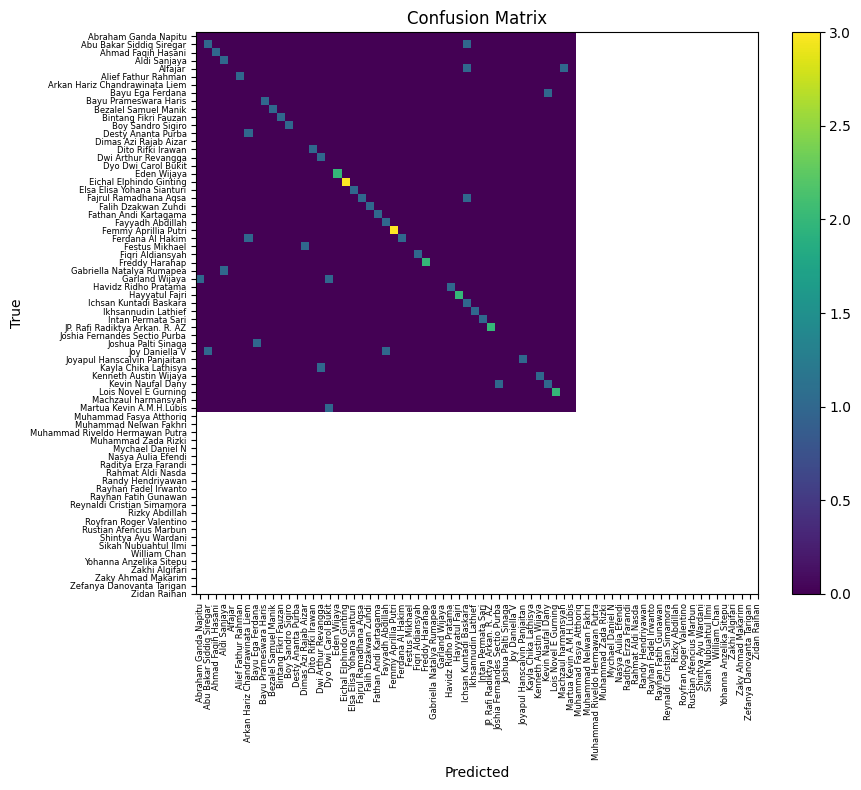


Classification Report:


ValueError: Number of classes, 47, does not match size of target_names, 70. Try specifying the labels parameter

In [ ]:
# =========================
# 9. EVALUASI LENGKAP (CONFUSION MATRIX, PRECISION, RECALL, F1)
# =========================

def evaluate_with_metrics(model, loader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    num_classes = len(class_names)
    all_label_ids = np.arange(num_classes)  # 0..69 → paksa 70 kelas

    print(f"Total kelas (class_names): {num_classes}")
    print(f"Kelas yang muncul di val : {np.unique(all_labels)}")

    # =========================
    # 1) CONFUSION MATRIX 70x70
    # =========================
    cm = confusion_matrix(
        all_labels,
        all_preds,
        labels=all_label_ids
    )

    print("Confusion Matrix (raw counts):")
    print(cm)
    print(f"Shape of confusion matrix: {cm.shape}")  # harus (70, 70)

    plt.figure(figsize=(10, 8))
    im = plt.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, class_names, rotation=90, fontsize=5)
    plt.yticks(tick_marks, class_names, fontsize=5)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # =========================
    # 2) CLASSIFICATION REPORT
    # =========================
    print("\nClassification Report (70 kelas, yg kosong akan 0):")
    print(classification_report(
        all_labels,
        all_preds,
        labels=all_label_ids,
        target_names=class_names,
        digits=4,
        zero_division=0
    ))

    # =========================
    # 3) METRIK GLOBAL
    # =========================
    acc = accuracy_score(all_labels, all_preds)

    prec_macro = precision_score(
        all_labels, all_preds,
        labels=all_label_ids,
        average='macro',
        zero_division=0
    )
    rec_macro = recall_score(
        all_labels, all_preds,
        labels=all_label_ids,
        average='macro',
        zero_division=0
    )
    f1_macro = f1_score(
        all_labels, all_preds,
        labels=all_label_ids,
        average='macro',
        zero_division=0
    )

    prec_weighted = precision_score(
        all_labels, all_preds,
        labels=all_label_ids,
        average='weighted',
        zero_division=0
    )
    rec_weighted = recall_score(
        all_labels, all_preds,
        labels=all_label_ids,
        average='weighted',
        zero_division=0
    )
    f1_weighted = f1_score(
        all_labels, all_preds,
        labels=all_label_ids,
        average='weighted',
        zero_division=0
    )

    print(f"\nAccuracy     : {acc:.4f}")
    print(f"Macro Avg   - Precision: {prec_macro:.4f}, Recall: {rec_macro:.4f}, F1: {f1_macro:.4f}")
    print(f"Weighted Avg- Precision: {prec_weighted:.4f}, Recall: {rec_weighted:.4f}, F1: {f1_weighted:.4f}")

    metrics_summary = {
        "accuracy": acc,
        "precision_macro": prec_macro,
        "recall_macro": rec_macro,
        "f1_macro": f1_macro,
        "precision_weighted": prec_weighted,
        "recall_weighted": rec_weighted,
        "f1_weighted": f1_weighted,
    }

    return cm, metrics_summary

cm, metrics = evaluate_with_metrics(model, val_loader, class_names, device)

In [ ]:

# =========================
# 10. SAVE MODEL TERBAIK
# =========================

save_path = "efficientnet_b0_best.pth"
torch.save({
    "model_state_dict": model.state_dict(),
    "num_classes": num_classes,
    "class_names": class_names,
}, save_path)

print(f"Model terbaik disimpan ke: {save_path}")
